<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2020/07/dataset-with-mask-1536x844.png)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset; namely, the Correctly Masked Face, the Incorrectly Masked Face and their combination for the global masked face detection. This dataset serves the objective of classifying faces that are:
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

### Import Required packages

In [ ]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob, os
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
import pandas as pd
from skimage.io import imread, imshow
import tensorflow as tf

## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

In [ ]:
# YOUR CODE HERE
path = '/content/MP2_FaceMask_Dataset/*/*/*'
image_files = glob.glob(path)
len(image_files)

6319

In [ ]:
img_features = []
for file_name in image_files:
    img_array = np.array([])
    record_type = file_name.split("/")[3]
    img_array = np.hstack((img_array, record_type))

    mask_type =  file_name.split("/")[4]
    img_array = np.hstack((img_array, mask_type))

    img = imread(file_name, as_gray=False)
    img_shape = img.shape
    img_array = np.hstack((img_array, img_shape))

    img_features.append(img_array)

df = pd.DataFrame(img_features)


In [ ]:
df.columns = ['record_type', 'mask_type', 'width', 'height', 'depth']
df.head()

,record_type,mask_type,width,height,depth
0,test,without_mask,160,160,3
1,test,without_mask,160,160,3
2,test,without_mask,160,160,3
3,test,without_mask,217,232,3
4,test,without_mask,160,160,3


In [ ]:
df[['width', 'height', 'depth']].astype(int).describe()

,width,height,depth
count,6319.000000,6319.000000,6319.0
mean,449.470802,435.327267,3.0
std,396.498827,387.515648,0.0
min,141.000000,110.000000,3.0
25%,160.000000,160.000000,3.0
50%,160.000000,160.000000,3.0
75%,1024.000000,1024.000000,3.0
max,5184.000000,3456.000000,3.0


In [ ]:
summary = df.groupby('record_type')['mask_type'].count()
summary

record_type
test     1263
train    5056
Name: mask_type, dtype: int64

In [ ]:
train_df = df[df['record_type'] == 'train']
test_df = df[df['record_type'] == 'test']
train_df.shape, test_df.shape

((5056, 5), (1263, 5))

Text(0.5, 1.0, 'Files by Mask types in Train data')

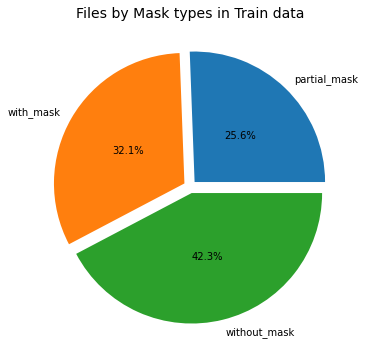

In [ ]:
data = train_df.groupby('mask_type')['mask_type'].count()
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*3, labels=labels, pctdistance=0.5)
plt.title("Files by Mask types in Train data", fontsize=14)

Text(0.5, 1.0, 'Files by Mask types in Test data')

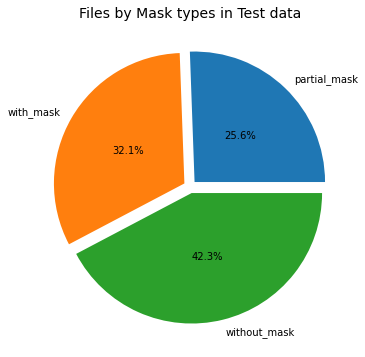

In [ ]:
data1 = test_df.groupby('mask_type')['mask_type'].count()
pie, ax = plt.subplots(figsize=[10,6])
labels = data1.keys()
plt.pie(x=data1, autopct="%.1f%%", explode=[0.05]*3, labels=labels, pctdistance=0.5)
plt.title("Files by Mask types in Test data", fontsize=14)

### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [ ]:
# YOUR CODE HERE
batch_size = 32
gen = ImageDataGenerator(validation_split = 0.2,
                         width_shift_range = 0.005,
                         height_shift_range = 0.005,
                         rotation_range = 0,
                         horizontal_flip = False)

trainGenerator = gen.flow_from_directory(
        directory=TRAINING_DIR,
        subset='training',
        target_size = (160, 160),
        batch_size = batch_size,
        shuffle=True)

validGenerator = gen.flow_from_directory(
        directory=TRAINING_DIR,
        subset='validation',
        target_size = (160, 160),
        batch_size = batch_size,
        shuffle=True)

testGenerator = gen.flow_from_directory(
        directory=VALIDATION_DIR,
        target_size = (160, 160),
        batch_size = batch_size,
        shuffle=True)

Found 4025 images belonging to 3 classes.
Found 1004 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


### Visualize the sample images of each class using data generator

Hint: plt.subplot

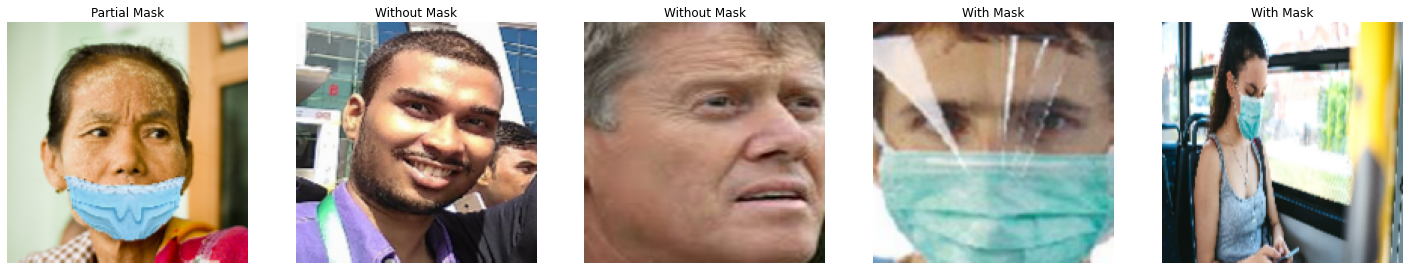

In [ ]:
# YOUR CODE HERE
f, ax = plt.subplots(1, 5, figsize=(25,25))

for row in range(5):
  img, label = trainGenerator.next()
  if (label[0][0] == 1): title = 'Partial Mask'
  if (label[0][1] == 1): title = 'With Mask'
  if (label[0][2] == 1): title = 'Without Mask'
  ax[row].imshow(img[0].astype('uint8'))
  ax[row].set_title(title)
  ax[row].axis('off')
plt.show()

In [ ]:
len(trainGenerator.labels)

4025

## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [ ]:
model = Sequential([
                    Conv2D(64, (3, 3), activation = "relu", padding = 'valid'),
                    Conv2D(64, (3, 3), activation = "relu", padding = 'valid'),
                    MaxPooling2D(pool_size=(3, 3)),
                    Conv2D(128, (3, 3), activation = "relu", padding = 'valid'),
                    Conv2D(128, (3, 3), activation = "relu", padding = 'valid'),
                    MaxPooling2D(pool_size=(3, 3)),
                    Flatten(),
                    Dense(128, activation = "relu"),
                    Dense(3, activation = "sigmoid")
                    ])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(trainGenerator, epochs = 5, validation_data = validGenerator)

Epoch 1/5
126/126 [==============================] - 55s 438ms/step - loss: 0.1914 - accuracy: 0.8991 - val_loss: 0.2345 - val_accuracy: 0.8835
Epoch 2/5
126/126 [==============================] - 55s 438ms/step - loss: 0.1033 - accuracy: 0.9548 - val_loss: 0.1369 - val_accuracy: 0.9293
Epoch 3/5
126/126 [==============================] - 55s 439ms/step - loss: 0.0842 - accuracy: 0.9660 - val_loss: 0.1638 - val_accuracy: 0.9462
Epoch 4/5
126/126 [==============================] - 55s 438ms/step - loss: 0.0538 - accuracy: 0.9766 - val_loss: 0.1518 - val_accuracy: 0.9432
Epoch 5/5
126/126 [==============================] - 55s 440ms/step - loss: 0.0418 - accuracy: 0.9836 - val_loss: 0.0654 - val_accuracy: 0.9701


## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [ ]:
# YOUR CODE HERE
model = keras.models.Sequential([
                                 Conv2D(64, (3, 3), activation = "relu", padding = 'valid'),
                                 #Conv2D(64, (3, 3), activation = "relu", padding = 'valid'),
                                 VGG16(weights = 'imagenet', include_top = False, input_shape=(160,160,3)).layers[2]
                                ])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

In [ ]:
model.predict(testGenerator)

InvalidArgumentError: ignored

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
     async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

clear_mask_image_path = 'https://image.made-in-china.com/2f0j00ZUnfveKhfOuR/Plastic-Face-Masks-Manufacturer-Spot-Isolation-Mask-Faceshield-PC-Dust-Protective-Masks-Transparent.jpg'
import requests
from IPython.display import Image
try:
  #filename = take_photo()
  img = PIL.Image.open(requests.get(clear_mask_image_path, stream=True).raw)
  img.save(r'photo.jpg')
  #print('Saved to {}'.format(filename))
  #display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which model accept.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

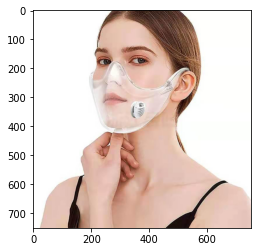

In [ ]:
features = PIL.Image.open("photo.jpg")
plt.imshow(features);
# YOUR CODE HERE to predict the image

In [ ]:
img = imread('photo.jpg')
image_resized = tf.image.resize(img, size=(160,160))
Y_pred = model.predict(image_resized)
Y_pred

### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- What process was followed to tune the hyperparameters?
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- Discuss the confusion matrix in terms of the misclassifications

### Instructions for preparing Kaggle competition predictions

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).

Refer [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1ZhCs4VHkXT2HLITL5ZJlZbgUSFIeWYrU/view?usp=sharing) for more information.